## Credit Card fraud detection - Using Sampling and KNN

Partners for this Homework are:
Pinaki Bhagat
Sydney Correa

We explored ensemble learning algorithms (RandomForest, ExtraTrees, AdaBoost, GradientBoost, XGBoost) and KNN to figure out the change in accuracy of predicting the fraudulent transactions in the credit card dataset.

Dataset
The datasets contains transactions made by credit cards in September 2013 by European cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.
Due to confidentiality of data, original features are masked and the dataset contains only numerical input variables which are the result of a PCA transformation. Features “Time” and “Amount” are not transformed and indicates the seconds elapsed between each transaction and the first transaction in the dataset and transaction amount respectively.

##### Import all python libraries

In [1]:
# special IPython command to prepare the notebook for matplotlib
%matplotlib inline 

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt



from datetime import datetime
import requests
from io import BytesIO
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.manifold import TSNE

# special matplotlib command for global plot configuration
from matplotlib import rcParams
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

import sklearn
from sklearn import neighbors, decomposition, metrics, preprocessing
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics

from sklearn import decomposition, preprocessing
from scipy.spatial import distance

import math
import warnings


#RANDOM_SEED=42
SEED = 0 # for reproducibility



warnings.simplefilter("ignore")

##### Download credit card dataset

In [2]:
sensor_train = pd.read_csv("creditcard.csv")

print(sensor_train.head)

<bound method NDFrame.head of             Time         V1         V2        V3        V4        V5  \
0            0.0  -1.359807  -0.072781  2.536347  1.378155 -0.338321   
1            0.0   1.191857   0.266151  0.166480  0.448154  0.060018   
2            1.0  -1.358354  -1.340163  1.773209  0.379780 -0.503198   
3            1.0  -0.966272  -0.185226  1.792993 -0.863291 -0.010309   
4            2.0  -1.158233   0.877737  1.548718  0.403034 -0.407193   
5            2.0  -0.425966   0.960523  1.141109 -0.168252  0.420987   
6            4.0   1.229658   0.141004  0.045371  1.202613  0.191881   
7            7.0  -0.644269   1.417964  1.074380 -0.492199  0.948934   
8            7.0  -0.894286   0.286157 -0.113192 -0.271526  2.669599   
9            9.0  -0.338262   1.119593  1.044367 -0.222187  0.499361   
10          10.0   1.449044  -1.176339  0.913860 -1.375667 -1.971383   
11          10.0   0.384978   0.616109 -0.874300 -0.094019  2.924584   
12          10.0   1.249999  -1.22

##### Drop the 'Time' feature from dataset and scale the amount feature

In [4]:
from sklearn.preprocessing import StandardScaler

data = sensor_train.drop(['Time'], axis=1)
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

In [6]:
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,0


##### Break the dataframe into train, validation and test set

In [7]:
X= data
X=X.drop(['Class'], axis=1)
y = data['Class']

print(X.head())
y.head()

         V1        V2        V3        V4        V5        V6        V7  \
0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10    ...          V20       V21       V22  \
0  0.098698  0.363787  0.090794    ...     0.251412 -0.018307  0.277838   
1  0.085102 -0.255425 -0.166974    ...    -0.069083 -0.225775 -0.638672   
2  0.247676 -1.514654  0.207643    ...     0.524980  0.247998  0.771679   
3  0.377436 -1.387024 -0.054952    ...    -0.208038 -0.108300  0.005274   
4 -0.270533  0.817739  0.753074    ...     0.408542 -0.009431  0.798278   

        V23       V24       V25       V26       V27       V28    Amount  
0 -0.110474  0.066928  0

0    0
1    0
2    0
3    0
4    0
Name: Class, dtype: int64

In [8]:
X_train, X_test1, y_train, y_test1 = train_test_split(X, y, stratify = y, test_size=0.4, random_state=SEED)
X_Val, X_test, y_Val, y_test = train_test_split(X_test1, y_test1, stratify = y_test1, test_size=0.5, random_state=SEED)

In [10]:
y_train.head()

163563    0
259157    0
212245    0
44628     0
100237    0
Name: Class, dtype: int64

##### Perform SMOTE for handling class imbalance

In [24]:
import imblearn
from imblearn.over_sampling import SMOTE

In [25]:
#UP Sampling of minority class
class_counts = np.bincount(y_train.astype(int))
print(class_counts)

[170589    295]


In [26]:
np.bincount(y_train.astype(int))*100/len(y_train)

array([99.82736827,  0.17263173])

### SMOTE inflates the number for the Class

In [27]:
sm = SMOTE(random_state=SEED)
X_train_upsampled, y_train_upsampled = sm.fit_sample(X_train, y_train)
np.bincount(y_train_upsampled.astype(int))
np.bincount(y_train_upsampled.astype(int))*100/len(y_train_upsampled)
print(X_train_upsampled.shape)
print(y_train_upsampled.shape)

(341178, 29)
(341178,)


In [28]:
X_train = X_train_upsampled
y_train = y_train_upsampled

In [29]:
X_test.shape

(56962, 29)

In [30]:
print('X_train :', X_train.shape)
print('X_test1 :', X_test1.shape)
print('y_train :', y_train.shape)
print('y_test1 :', y_test1.shape)
print('X_Val :', X_Val.shape)
print('X_test :', X_test.shape)
print('y_Val :', y_Val.shape)
print('y_test :', y_test.shape)



X_train : (341178, 29)
X_test1 : (113923, 29)
y_train : (341178,)
y_test1 : (113923,)
X_Val : (56961, 29)
X_test : (56962, 29)
y_Val : (56961,)
y_test : (56962,)


In [ ]:
scores = []

for ne in range(4,40,4):
    clf = RandomForestClassifier(n_estimators = ne, random_state=82)
    score_list = cross_val_score(clf, X_train, y_train, cv=5,n_jobs=-1) #returns accuracy
    #score_list = cross_val_score(clf, X, Y, cv=10, scoring='accuracy') #same as above
    scores.append(score_list)

In [ ]:
scores

In [ ]:
plt.figure(figsize=(12,5))
plt.xlabel('Number of trees')
plt.ylabel('Classification score')
plt.title('Classification score as a function of the number of trees')
sns.boxplot(x=np.arange(4,40,4),y=scores)
plt.show()

##### This section is to find out the best parameter k for the given dataset. It then trains the model with best hyperparameter k and uses that to predict the class

The optimal number of neighbors is 1


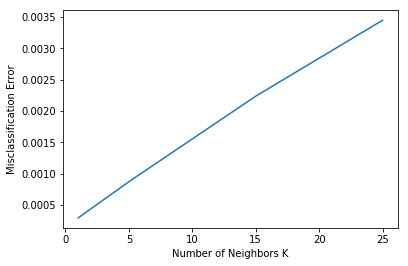

In [31]:
from sklearn.neighbors import KNeighborsClassifier

#Hyperparameter Tuning for K
#K_list=list(range(1,20))
K_list=[1,5,15,25]


#create empty list
cv_scores=[]

#perform K search
for k in K_list:
    knn=KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    scores=cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
    

#Plotting misclassification error

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = K_list[MSE.index(min(MSE))]
print ("The optimal number of neighbors is %d" % optimal_k)

# plot misclassification error vs k
plt.plot(K_list, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

#Look how the number of neighbors drastically increases the MSE rate

# Try KNN to see how well it predicts fraud on the undersampled dataset
knn=KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(X_train, y_train)
y_knn_predict=knn.predict(X_test)

In [36]:
plt.figure(figsize=(8,5))
random_state = np.random.RandomState(37)
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []


probas_ = knn.fit(X_train,y_train).predict_proba(X_test)
# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
mean_tpr += np.interp(mean_fpr, fpr, tpr)
mean_tpr[0] = 0.0
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC, estimators: %d \n(AUC = %0.3f)' % (knn.n_neighbors, roc_auc))


plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve choice of kernel comparison')
plt.legend(loc="lower right")
plt.show()

NameError: name 'roc_curve' is not defined

<Figure size 576x360 with 0 Axes>